In [56]:
import gensim
import fasttext as ft
import re
from nltk.corpus import stopwords
import itertools
from keras.layers.core import Activation, Dense, Dropout, SpatialDropout1D
from keras.layers.embeddings import Embedding
from keras.layers.wrappers import TimeDistributed
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
import collections 
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

In [57]:
articles1 = pd.read_csv('articles1.csv')
articles = articles1.iloc[:100,:]

stopset = set(stopwords.words('english'))
def cleaner(x):
    x = nltk.word_tokenize(str(x))
    x = [w for w in x if not w in stopset]
    return x

articles.content = articles.content.map(lambda x:cleaner(x))
articles.title = articles.title.map(lambda x:cleaner(x))

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [58]:
articles.head()

,Unnamed: 0,id,title,publication,author,date,year,month,url,content
0,0,17283,"[House, Republicans, Fret, About, Winning, The...",New York Times,Carl Hulse,2016-12-31,2016.0,12.0,NaN,"[WASHINGTON, —, Congressional, Republicans, ne..."
1,1,17284,"[Rift, Between, Officers, Residents, Killings,...",New York Times,Benjamin Mueller and Al Baker,2017-06-19,2017.0,6.0,NaN,"[After, bullet, shells, get, counted, ,, blood..."
2,2,17285,"[Tyrus, Wong, ,, ‘, Bambi, ’, Artist, Thwarted...",New York Times,Margalit Fox,2017-01-06,2017.0,1.0,NaN,"[When, Walt, Disney, ’, “, Bambi, ”, opened, 1..."
3,3,17286,"[Among, Deaths, 2016, ,, Heavy, Toll, Pop, Mus...",New York Times,William McDonald,2017-04-10,2017.0,4.0,NaN,"[Death, may, great, equalizer, ,, ’, necessari..."
4,4,17287,"[Kim, Jong-un, Says, North, Korea, Is, Prepari...",New York Times,Choe Sang-Hun,2017-01-02,2017.0,1.0,NaN,"[SEOUL, ,, South, Korea, —, North, Korea, ’, l..."


In [59]:
#maxlen = 0
#word_freqs = collections.Counter()
#unique = []
#num_recs = 0
#for line in range(len(articles.content)):
 #   words = articles.content[line]
  #  if len(words)>maxlen:
   #     maxlen = len(words)
    #for word in words:
     #   word_freqs[word] += 1
      #  if word not in unique:
       #     unique.append(word)
    #num_recs += 1

vocab = []
word = []
for i in range(len(articles.content)):
    for j in range(len(articles.content[i])):
        word.append(articles.content[i][j])
        if articles.content[i][j] not in vocab:
            vocab.append(articles.content[i][j])
#chars = list(set(data))
VOCAB_SIZE = len(vocab)

seq_length = 1
print('Data length: {} words'.format(len(word)))
print('Vocabulary size: {} words'.format(VOCAB_SIZE))

ix_to_word = {ix:word for ix, word in enumerate(vocab)}
word_to_ix = {word:ix for ix, word in enumerate(vocab)}
    
X = np.zeros((int(len(word)/seq_length), seq_length, VOCAB_SIZE))
y = np.zeros((int(len(word)/seq_length), seq_length, VOCAB_SIZE))
y_bar = np.zeros((int(len(word)/seq_length), seq_length, VOCAB_SIZE))
for i in range(0, int(len(articles.content)/seq_length)):
    X_sequence = word[i*seq_length:(i+1)*seq_length]
    X_sequence_ix = [word_to_ix[value] for value in X_sequence]
    input_sequence = np.zeros((seq_length, VOCAB_SIZE))
    for j in range(seq_length):
        input_sequence[j][X_sequence_ix[j]] = 1.
        X[i] = input_sequence

    y_sequence = word[i*seq_length+1:(i+1)*seq_length+1]
    y_sequence_ix = [word_to_ix[value] for value in y_sequence]
    target_sequence = np.zeros((seq_length, VOCAB_SIZE))
    for j in range(seq_length):
        target_sequence[j][y_sequence_ix[j]] = 1
        y[i] = target_sequence
        
    y_bar_sequence = word[i*seq_length-1:(i+1)*seq_length-1]
    y_bar_sequence_ix = [word_to_ix[value] for value in y_sequence]
    target_sequence_bar = np.zeros((seq_length, VOCAB_SIZE))
    for j in range(seq_length):
        target_sequence_bar[j][y_sequence_ix[j]] = 1
        y_bar[i] = target_sequence_bar

Data length: 95703 words
Vocabulary size: 14998 words


In [60]:
xtrain = X[:int(.75*len(X)), :, :]
ytrain = y[:int(.75*len(X)), :, :]
xtest = X[int(.75*len(X)):, :, :]
ytest = y[int(.75*len(X)):, :, :]

In [61]:
x_train = X[:int(.75*len(X)), :, :]
y_train = y_bar[:int(.75*len(X)), :, :]
x_test = X[int(.75*len(X)):, :, :]
y_test = y_bar[int(.75*len(X)):, :, :]

In [62]:
model = Sequential()
model.add(LSTM(1200, input_shape=(None, VOCAB_SIZE), return_sequences=True))
for i in range(2):
  model.add(LSTM(600, return_sequences=True))
model.add(TimeDistributed(Dense(VOCAB_SIZE)))
model.add(Activation('softmax'))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics = ["accuracy"])

In [63]:
#vocab_size = min(max_features, len(word_freqs))
#word2index = {x[0]: i+2 for i,x in enumerate(word_freqs.most_common(max_features))}
#word2index["UNK"] = 1
#index2word = {v:k for k, v in word2index.items()}
BATCH_SIZE = 1000
history = model.fit(xtrain, ytrain, batch_size=BATCH_SIZE, verbose=1, epochs=2, validation_data=(xtest, ytest))

Train on 71777 samples, validate on 23926 samples
Epoch 1/2
71777/71777 [==============================] - 271s 4ms/step - loss: 0.0134 - acc: 0.0279 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 2/2
71777/71777 [==============================] - 266s 4ms/step - loss: 0.0133 - acc: 2.7864e-05 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00


In [64]:
#word_sequence = pd.Series(words)
length = 1
ix = [np.random.randint(VOCAB_SIZE)]
y_word = [ix_to_word[ix[-1]]]
x = np.zeros((1, length, VOCAB_SIZE))
for i in range(length):
    # appending the last predicted character to sequence
    x[0, i, :][ix[-1]] = 1
    #print(ix_to_word[ix[-1]], end="")
    ix = np.argmax(model.predict(x[:, :i+1, :])[0], 1)
    y_word.append(ix_to_word[ix[-1]])
    if y_word[-1] == '.':
        break
print((' ').join(y_word))

bully Republicans


In [65]:
#x = pd.get_dummies(word_sequence)
#y = x.shift(-1)
BATCH_SIZE_BAR = 1000
history_bar = model.fit(x_train, y_train, batch_size=BATCH_SIZE_BAR, verbose=1, epochs=2, validation_data=(x_test, y_test))

Train on 71777 samples, validate on 23926 samples
Epoch 1/2
71777/71777 [==============================] - 267s 4ms/step - loss: 0.0123 - acc: 6.9660e-05 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 2/2
71777/71777 [==============================] - 266s 4ms/step - loss: 0.0084 - acc: 5.5728e-05 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00


In [71]:
#word_sequence = pd.Series(words)
length_bar = 1
ix_bar = [np.random.randint(VOCAB_SIZE)]
y_word_bar = [ix_to_word[ix_bar[-1]]]
x_bar = np.zeros((1, length_bar, VOCAB_SIZE))
for i in range(length_bar):
    # appending the last predicted character to sequence
    x_bar[0, i, :][ix_bar[-1]] = 1
    #print(ix_to_word[ix[-1]], end="")
    ix_bar = np.argmax(model.predict(x_bar[:, :i+1, :])[0], 1)
    y_word_bar.append(ix_to_word[ix_bar[-1]])
    if y_word_bar[-1] == '.':
        break
    
y_word_bar = reversed(y_word_bar)
print((' ').join(y_word_bar))

Republicans brains


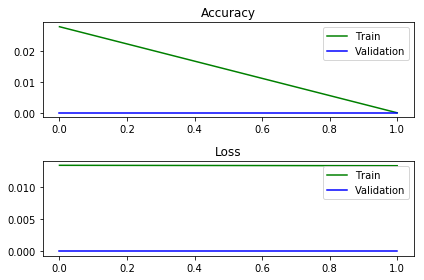

In [72]:
import matplotlib.pyplot as plt
plt.subplot(211)
plt.title("Accuracy")
plt.plot(history.history["acc"], color="g", label="Train")
plt.plot(history.history["val_acc"], color="b", label="Validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(history.history["loss"], color="g", label="Train")
plt.plot(history.history["val_loss"], color="b", label="Validation")
plt.legend(loc="best")
plt.tight_layout()

plt.show()

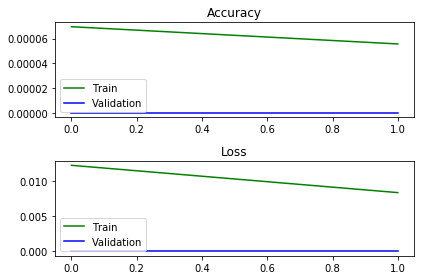

In [73]:
plt.subplot(211)
plt.title("Accuracy")
plt.plot(history_bar.history["acc"], color="g", label="Train")
plt.plot(history_bar.history["val_acc"], color="b", label="Validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(history_bar.history["loss"], color="g", label="Train")
plt.plot(history_bar.history["val_loss"], color="b", label="Validation")
plt.legend(loc="best")
plt.tight_layout()

plt.show()